# Kaggle Project - Titanic Survivors Classification Notebook #

*Though chapters to this notebook are numbered into traditional steps (data cleaning, feature engineering etc.), I follow a 4D framework as an overarching structure to my projects, as it gives me consistent clarity as I develop my skills. The 4D steps are as following:*

**DEFINE** (define the problem task)

**DISCOVER** (explore the data and understand it, so it is best prepared for modelling)

**DEVELOP** (apply feature manipulation and modelling techniques to create as accurate predictions as possible)

**DEPLOY** (this step would be deploying the model into production and tracking performance against the company KPI's from the 'DEFINE' stage of the 4D process, however, for the purpose of this notebook this will simply be the submission to Kaggle). 

## *DEFINE - the problem*

### 1. Intro

This is a notebook for an end to end data science project. The task at hand is to predict whether a passenger survived or not on the titanic based on historic passenger data. This is a project from Kaggle, who provided the datasets to work on. 

Firstly, the data is imported into Pandas DataFrames:

In [1]:
# import pandas
import pandas as pd
# dsHelper is a library of useful functions I have created for reproducibility in the future
import dsHelper as dsh

# read in the data files
train = pd.read_csv(r'C:\Users\steff\Documents\Python\My Projects\Titanic\train.csv')
test = pd.read_csv(r'C:\Users\steff\Documents\Python\My Projects\Titanic\test.csv')

# create a new DataFrame of all the features together
features = pd.concat([train, test])
# drop the 'Survived' target variable as this DataFrame is solely for feature space analysis
features.drop(columns=['Survived'], inplace=True)
# create dataframe dictionay to be able to loop over and manipulate columns simultaneously later in the notebook
df_dict = {'train':train, 'test':test, 'features':features}  

## *DISCOVER - the data*

*The dsHelper library was created by myself to store reusable functions that are useful for data science operations. It will be of constant use throughout this notebook. Please feel free to dive into the file if viewing on my GitHub.*

**Target variable exploration**

Firstly, the dsh library is used is for a visualization of the target variable, as well as printing some summary statistics:

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64


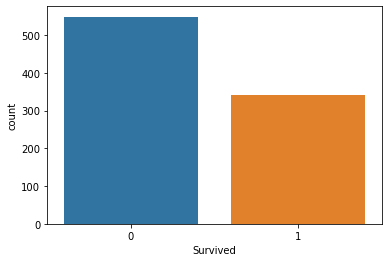

In [2]:
# plot the target variable counts and basic summary statistics 
dsh.target_variable_exploration(df_dict['train']['Survived'], 'classification')

Far more people died than survived on the titanic. 

This already gives a baseline model - 'Everyone dies' - would yield ~62% accuracy, so the model created by the end would have to far outperform this as a starting point. 

**Dataframe exploration**

Next, some DataFrame exploration is performed to assess what data cleaning/wrangling steps may have to be perfromed.

In [3]:
# explore the data
dsh.dataframe_exploration(df_dict['train'], 'train dataframe')
dsh.dataframe_exploration(df_dict['features'], 'features dataframe')



******************** BASIC EXPLORATION FOR DATAFRAME: ' train dataframe '

DATA TYPE:

 <class 'pandas.core.frame.DataFrame'>

DATA SHAPE:

 (891, 12)

DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

DUPLICATE DATA:

 0

DATA MISSING:

 PassengerId      0
Survived         0
Pc

As we scroll through the information above, we can extract some important points to consider for cleaning such as:

(1) Significant amount of missing entries in the 'Age' and 'Cabin' features. Likewise, the 'Fare' and 'Embarked' features have some missing entries though to a far lesser extent.  

(2) Number of unique values in 'Name' and 'PassengerId' features is equal to the total number of entries, therefore it is unlikely these features add any information in regards to probability of survival. Although not all entries are unique in the the 'Ticket' feature, there is also a problem of very high cardinality. 

(3) There are 5 non-numerical columns which will have to be addressed before modelling. 

### 2. Data Cleaning

**Missing Data**

In [4]:
# Print out the percentage of missing values for each feature
Cabin_missing_data_percentage = features['Cabin'].isna().sum() / len(features['Cabin'])
print('Percentage of missing data for the Cabin feature = ', round(Cabin_missing_data_percentage*100, 2),'%')
Age_missing_data_percentage = features['Age'].isna().sum() / len(features['Age'])
print('Percentage of missing data for the Age feature = ', round(Age_missing_data_percentage*100, 2),'%')
Fare_missing_data_percentage = features['Fare'].isna().sum() / len(features['Fare'])
print('Percentage of missing data for the Fare feature = ', round(Fare_missing_data_percentage*100, 2),'%')
Embarked_missing_data_percentage = features['Embarked'].isna().sum() / len(features['Embarked'])
print('Percentage of missing data for the Embarked feature = ', round(Embarked_missing_data_percentage*100, 2),'%')

Percentage of missing data for the Cabin feature =  77.46 %
Percentage of missing data for the Age feature =  20.09 %
Percentage of missing data for the Fare feature =  0.08 %
Percentage of missing data for the Embarked feature =  0.15 %


The 'Cabin' feature has so many missing values (77.5 %) that it is best to drop the column entirely as no educated inference on how to fill that amount of missing information can be reasonably made. 

The ratio of missing data for 'Fare' and 'Embarked' is so small that those can be filled with the median and mode values respectively. The rationale is that a continuous variable (Fare) can be reasonably filled with an average value, and a categorical variable (Embarked) can be reasonably filled with the most commonly occuring value.

As for the 'Age' feature, 20 % is a very significant amount of missing data so careful consideration is needed. For the purpose of this first notebook, the median is used. However, filling the missing ages with more educated values (by utilising other features) will be one of the first points to consider when improving this project.

In [5]:
for df in df_dict.values():
    
    # drop the Cabin column
    df.drop(columns=['Cabin'], inplace=True)
    
    # fill missing values for the 'Fare', 'Embarked' and 'Age' columns
    df['Fare'].fillna(features['Fare'].median(), inplace=True)
    df['Embarked'].fillna(list(features['Embarked'].mode())[0], inplace=True)
    df['Age'].fillna(features['Age'].median(), inplace=True)

**Unique Values**

The number of unique values of 'PassengerId' and 'Name' are equal to the total number of entries. PassengerId can be set as the new index as it is simply ordering all the entries. Looking into 'Name', the only information that could be extracted, such as mr/mrs, are already captured by other features. The decision is therefore made to drop this feature. 

The 'Ticket' feature has such high cardinality that it is also dropped. Note that this decision will be reviewed to improve the project later as there may be potential for useful information to be extracted from the ticket numbers.

In [6]:
columns_drop_list = ['Name', 'Ticket']

for df in df_dict.values():
    
    # reset the index to the PassenegrId
    df.set_index('PassengerId', inplace=True)
    
    # drop columns
    for col in columns_drop_list:
        
        df.drop(columns=[col], inplace=True)

The features can now be explored post cleaning to verify that missing data and features with high number of unique values have been dealt with.

In [7]:
# explore the feature space dataframe
dsh.dataframe_exploration(df_dict['features'], 'features dataframe')



******************** BASIC EXPLORATION FOR DATAFRAME: ' features dataframe '

DATA TYPE:

 <class 'pandas.core.frame.DataFrame'>

DATA SHAPE:

 (1309, 7)

DATA INFO:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Sex       1309 non-null   object 
 2   Age       1309 non-null   float64
 3   SibSp     1309 non-null   int64  
 4   Parch     1309 non-null   int64  
 5   Fare      1309 non-null   float64
 6   Embarked  1309 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 81.8+ KB

DUPLICATE DATA:

 237

DATA MISSING:

 Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

UNIQUE VALUES:

 Sex           2
Pclass        3
Embarked      3
SibSp         7
Parch         8
Age          98
Fare        281
dtype: int64

DATA HEAD:

    

**Non-numeric features**

The non-numerical data is to be adressed later in the feature engineering chapter.

### 3. EDA

In this chapter, the features are explored visually to better understand their distributions and relationships with the target variable, as well as potential options for feature engineering.

**Passenger class**

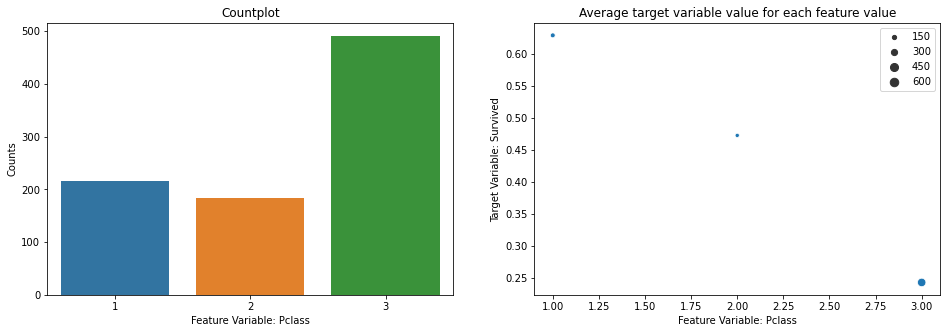

In [8]:
dsh.plot_feature(df_dict['train'], 'Pclass', 'Survived')

Clearly, the vast majority of passengers aboard the Titanic were 3rd class passengers, with the rest almost evenly split between 1st and 2nd class. As expected, there is a very clear negative correlation between class and survival percentage. This will undoubtedly be an important predictor.

**Travelling with Family**

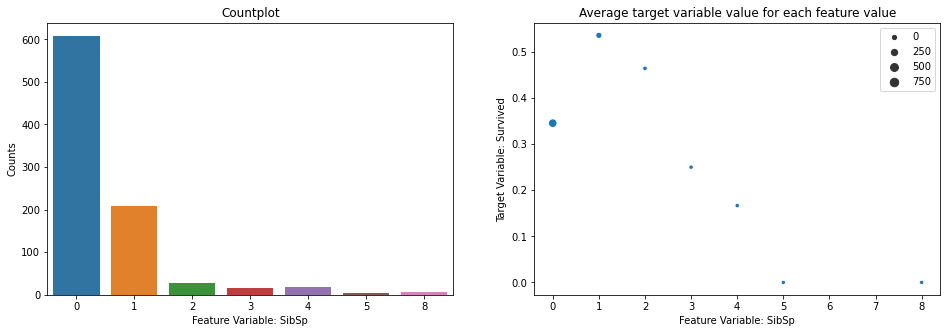

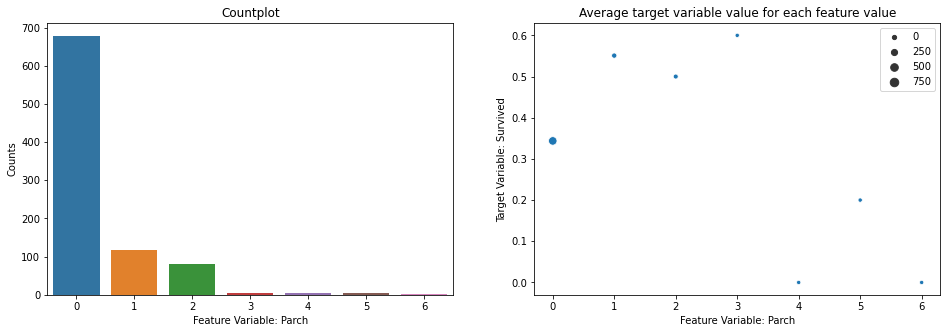

In [9]:
dsh.plot_feature(df_dict['train'], 'SibSp', 'Survived')
dsh.plot_feature(df_dict['train'], 'Parch', 'Survived')

The vast majority of passengers aboard the Titanic were travelling without family. There is a distinct negative correlation between the number of siblings/spouses a passenger was travelling with, and the survival percentage. Similarly, the survival percentage when considering number of parents/children also provides some valuable insight, in that groups of 1-3 appear to have had much higher chance of survival than groups of 4-6. 

These points can all be considered when creating new features: A good option will be to have a feature for being 'Alone', in a 'Small group' and in a 'Big group'.

**Age**

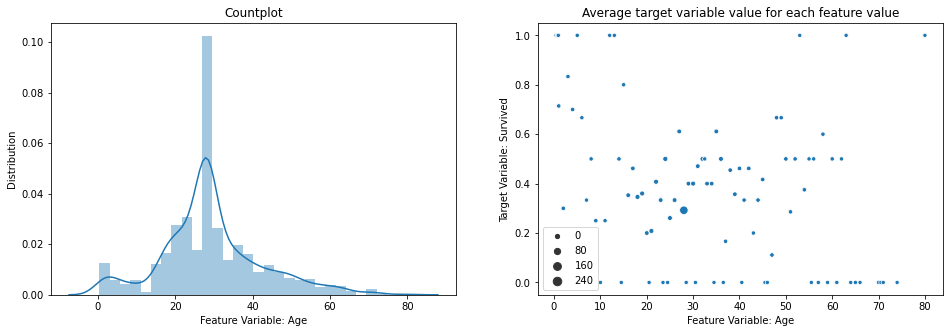

In [10]:
dsh.plot_feature(df_dict['train'], 'Age', 'Survived')

The distribution of ages shows the population on board the titanic was centered around people in their 20's and 30's. There is a spike in young children, though asides this, the distribution of ages curtains off until elderly age.

Here we see the negative aspect of the decision to fill missing values with the median. The huge spike in the late 20's is undoubtedly a misrepresentation of the true distribution. 

The survival percentages show this group of young children had the best chance of survival, however, it is difficult to discern any other significance age may play. A good approach will be to bin these ages into groups, and see if any correlation can be found that way. 

**Fare**

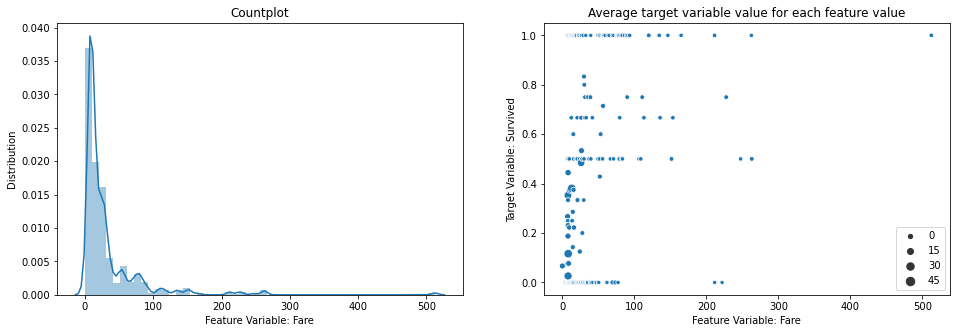

In [11]:
dsh.plot_feature(df_dict['train'], 'Fare', 'Survived')

The data for the 'Fare' is problematic in its raw form as there are a few very high fare prices that skew the data. Clearly from the distribution, there is a huge concentration of data at the low end of fares less than 50. This area should be explored further to gain a better understanding of this feature:

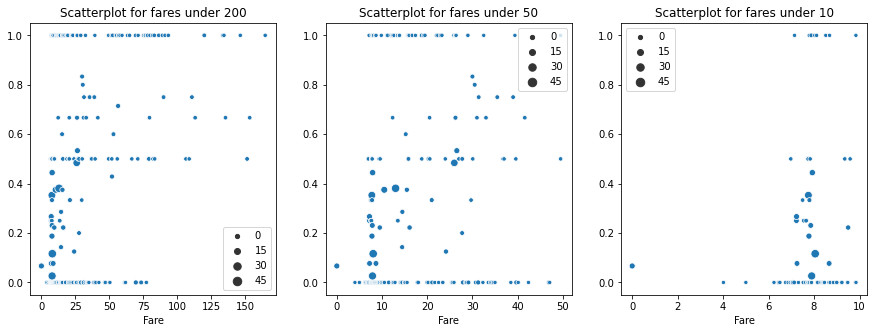

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

train = df_dict['train']

# upper limits for the fare value, to create different scatter plots against survival percentage
fare_limits = [200, 50, 10]
counts = []
means = []

for loop, fare_limit in enumerate(fare_limits):
    
    train_fare_limited = train[train['Fare']<fare_limit]
    counts.append(train_fare_limited.groupby('Fare')['Survived'].count())
    means.append(train_fare_limited.groupby('Fare')['Survived'].mean())

# create figure with subplots, each one zooming into the scatter plot of lower fares against survival percentage
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(ax=ax[0], x=means[0].index, y=means[0].values, size=counts[0].values)
ax[0].set_title('Scatterplot for fares under 200')
sns.scatterplot(ax=ax[1], x=means[1].index, y=means[1].values, size=counts[1].values)
ax[1].set_title('Scatterplot for fares under 50')
sns.scatterplot(ax=ax[2], x=means[2].index, y=means[2].values, size=counts[2].values)
ax[2].set_title('Scatterplot for fares under 10')
plt.show()

Overall, there appears to be a slight positive correlation between fare and survival percentage. Well over 50% of those who paid over 100 survived. There is a slight correlation between survival percentage and fare cost even at under 50, though what is clear, is a concentration of low survival rates for the lowest fares under 10. These plots will be of further use when deciding bin limits. 

**Sex**

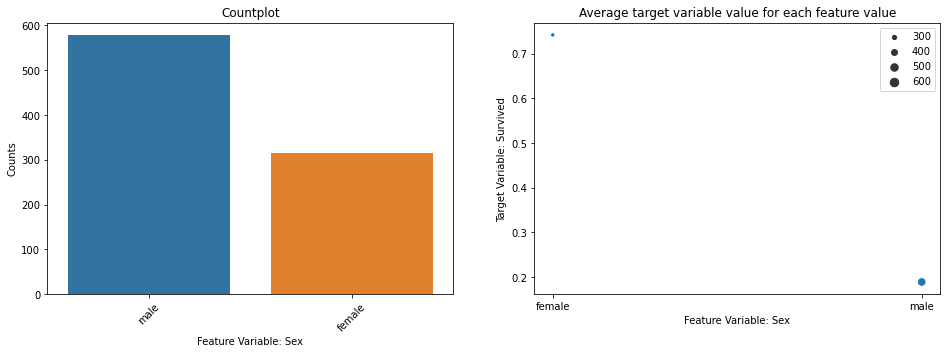

In [13]:
dsh.plot_feature(df_dict['train'], 'Sex', 'Survived')

Sex will unquestionably be one of the key predictors of survival on the Titanic, with only 20% of males surviving in this subset of the data, compared to 73% of females.

**Embarkation point**

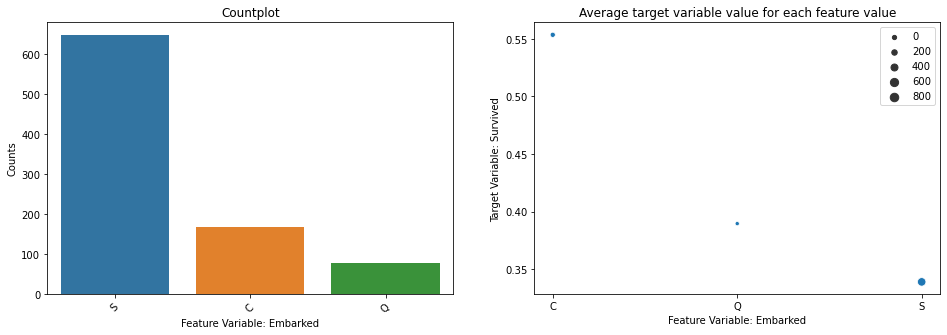

In [14]:
dsh.plot_feature(df_dict['train'], 'Embarked', 'Survived')

Finally, there is a significance in the place of embarkment. It could definately be speculated that the high count of passengers from Southampton is where the vast majority of low-fare-paying, 3rd-class passengers cam from, given the lower survival percentage. 

It would be interesting to delve into why passengers from Cherbourg in France had a much higher survival percentage, compared to the other 2 embarkation points in England. Were they higher class/fare passengers? Were their cabins located in different parts of the ship? These are all points to consider and demonstrates the importance of domain knowledge. 

**Correlation heatmap**

A very important characteristic to examine in the dataset is the correlation between variables. This is best visualized with a correlation heatmap.

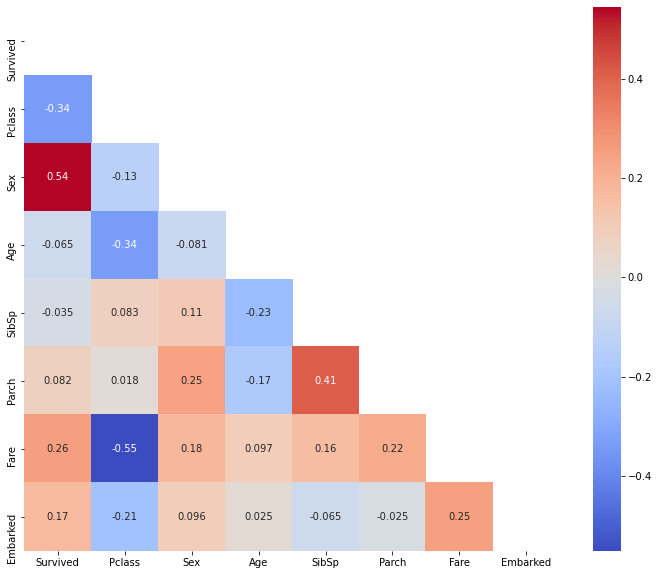

In [15]:
dsh.dataframe_correlation_heatmap(df_dict['train'], 'Survived')

The correlation heatmap gives a nice visualization to reaffirm some of the conclusions that were drawn from the previous EDA. The most significant features in terms of predicting survival were (in order): Sex, Class, Fare and the Embarkation point. 

However, thanks to some of the previous visualizations, clearly the remaining features can be binned into groups that would be potentially more powerful predictors such as age categories, or whether a person was travelling alone or in a group. 

As well as dealing with the non-numerical features, new potential features are to be explored in the next phase of this notebook, where feature engineering and model building is performed to predict passenger survival on the Titanic. 

## *DEVELOP*

After having grasped some understanding of the distributions of each feature and impact on survival, the objective now shifts to manipulating these features to make optimal use of the data to finally make predictions. To make the most impact with any model, the quality of data is absolutely paramount to any success.

### 4. Feature Engineering

The approach undertaken here is to break down the features into group categories, whereby average survival percentage can then be attributed to the group and input as a new feature to the model. This is label encoding. I.e. Passengers with ages between 40 and 60 may have an average survival of 55%. This value would be reflected in the new feature for all passengers pertaining to that age group.

**Binning continuous features into groups**

Firstly, the continuous features 'Age' and 'Fare', must be binned into groups. To decide on the group limits, a close look is taken at the previous work in the EDA section of this notebook to try to determine the best categories that produce the most variance in survival percentage. The resultant limits were the following:

In [16]:
# group limits (determined from observing EDA) and the corresponding labels 
age_bins = [0, 16, 25, 40, 60, 90]
age_labels = ['0to16', '16to25', '25to40', '40to60', '60to90']
fare_bins = [0, 10, 20, 50, 200, 513]
fare_labels = ['0to10', '10to20', '20to50', '50to200', '200toMax']

# loop through all the dataframes
for df in df_dict.keys():
    # create new columns with the corresponding binned group label
    df_dict[df] = dsh.bin_continuous_feature(df_dict[df], 'Age', age_bins, age_labels)
    df_dict[df] = dsh.bin_continuous_feature(df_dict[df], 'Fare', fare_bins, fare_labels)

The bin limits can of course be played around with to assess impact on model performance.  

**New features based on travelling companions**

A new feature is created as a result of some insight taken during the EDA of the 'Sibsp' and 'Parch' features. The new feature is simply the total number of companions.

In [17]:
# create the new feature 'Companions' by simply adding the sibling/spouse and parent/child columns together
for df in df_dict.keys():
    df_dict[df]['Companions'] = df_dict[df]['SibSp'] + df_dict[df]['Parch']

These are then binned into categories of people travelling alone, in a small group, and in a large group. From the EDA it was evident that these diffferences in companions definately had an impact on survival chances.

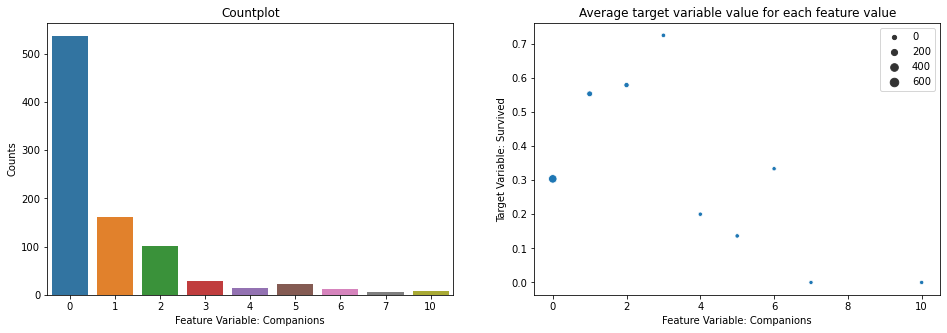

In [18]:
dsh.plot_feature(df_dict['train'], 'Companions', 'Survived')

The bin categories should aim to capture the different survival rates for these different group sizes.

In [19]:
companion_bins = [0, 1, 3, 11]
companion_labels = ['Alone', 'Small_group', 'Large_group']

for df in df_dict.keys():
    
    df_dict[df] = dsh.bin_continuous_feature(df_dict[df], 'Companions', companion_bins, companion_labels)

**Encode new categories with survival percentage associated to each group**

An example of the average survival percentage for each group, as well as the size of the group, is printed out below. These are the values that will be used to encode each new category that was created through binning. 

In [20]:
# use passenger class feature as an example
col_example = 'Pclass'
# dsh.group_stats is a function that computes various statistics on groups - here we are just interested in the group mean
group_means = dsh.group_stats(df_dict['train'], col_example, 'Survived')[[col_example, 'group_count', 'group_mean']]
display(group_means)

,Pclass,group_count,group_mean
0,1,216,0.629630
1,2,184,0.472826
2,3,491,0.242363


The following function get_mapping() is used to return a dictionary of each group category and its corresponding survival percentage average, to be then used as a map to convert all the group categories into numerical encodings that can finally be input into a model.

In [21]:
# define the function to return the mapping that will be used to numerically encode group categories
def get_mapping(df, col):
    
    mapping = {}
    
    for row, values in df.iterrows():
        
        mapping[values[col]] = values['group_mean']
        
    return mapping

Each categorical column, both the original ones ('Pclass', 'Sex', 'Embarked') and those created through binning ('Age_binned', 'Fare_binned', 'Companions_binned'), are now numerically encoded with average group survival percentage.

In [22]:
cols_to_encode = ['Pclass', 'Sex', 'Embarked', 'Age_binned', 'Fare_binned', 'Companions_binned']

# loop through each column we desire to encode with the group average survival percentage
for col in cols_to_encode:
    
    group_means = dsh.group_stats(df_dict['train'], col, 'Survived')[[col, 'group_mean']]
    mapping = get_mapping(group_means, col)
    # apply the mapping for each column to all the dataframes, creating new columns with '_encoded' added as a suffix
    for df in df_dict.keys():
        
        df_dict[df][col+'_encoded'] = df_dict[df][col].map(mapping)

Subsequently, the original categorical columns can all be dropped as they are of no further use. 

In [23]:
# drop original categorical columns
for df in df_dict.values():
    df.drop(columns=cols_to_encode, inplace=True)

The final dataframes that will be used for the modelling stage in this notebook can now be shown:

In [24]:
display(df_dict['train'].sample(5))
display(df_dict['test'].sample(5))

,Survived,Age,SibSp,Parch,Fare,Companions,Pclass_encoded,Sex_encoded,Embarked_encoded,Age_binned_encoded,Fare_binned_encoded,Companions_binned_encoded
PassengerId,,,,,,,,,,,,
816,0,28.0,0,0,0.0000,0,0.629630,0.188908,0.339009,0.362222,0.199405,0.303538
202,0,28.0,8,2,69.5500,10,0.242363,0.188908,0.339009,0.362222,0.673759,0.340659
282,0,28.0,0,0,7.8542,0,0.242363,0.188908,0.339009,0.362222,0.199405,0.303538
493,0,55.0,0,0,30.5000,0,0.629630,0.188908,0.339009,0.394161,0.418605,0.303538
751,1,4.0,1,1,23.0000,2,0.472826,0.742038,0.339009,0.590361,0.418605,0.562738


,Age,SibSp,Parch,Fare,Companions,Pclass_encoded,Sex_encoded,Embarked_encoded,Age_binned_encoded,Fare_binned_encoded,Companions_binned_encoded
PassengerId,,,,,,,,,,,
1170,30.0,1,0,21.0000,1,0.472826,0.188908,0.339009,0.362222,0.418605,0.562738
917,50.0,1,0,14.5000,1,0.242363,0.188908,0.339009,0.394161,0.424581,0.562738
1269,21.0,0,0,11.5000,0,0.472826,0.188908,0.339009,0.353846,0.424581,0.303538
1231,28.0,0,0,7.2292,0,0.242363,0.188908,0.553571,0.362222,0.199405,0.303538
905,63.0,1,0,26.0000,1,0.472826,0.188908,0.339009,0.269231,0.418605,0.562738


### 5. Modelling

To begin modelling, all the necessary imports are made from the sklearn library.

In [44]:
# sklearn library imports for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, plot_roc_curve

Firstly, using train_test_split from sklearn, the training dataset is split further into new training and test sets for the purpose of model validation. Once the optimal model is tuned, then predictions can be made on the original test set which the model has not yet seen.

In [45]:
x_tr, x_te, y_tr, y_te = train_test_split(df_dict['train'].drop(columns='Survived'), df_dict['train']['Survived'], random_state=10, test_size=0.2)
results = {}

**Baseline model - Logistic regression model**

For the purpose of this project, a logistic regression classifier is used as a baseline predictor. The logistic regression model is an obvious first choice linear model for a dichotomous classification task. It has been shown to be a good model to predict categorical outcomes (surviving or not).

In [46]:
# applying a logistic regression model to the data as a baseline prediction
lr = LogisticRegression(solver='liblinear')
lr.fit(x_tr, y_tr)
y_pr = lr.predict(x_te)
results['lr_baseline'] = {'matrix':confusion_matrix(y_te, y_pr), 'report':classification_report(y_te, y_pr)}

The performance can then be analysed by creating visualizations of the confusion matrix and classification report.

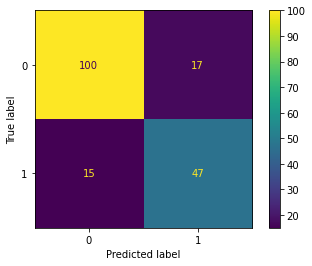

In [47]:
plot_confusion_matrix(rf1, x_te, y_te)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       117
           1       0.78      0.69      0.74        62

    accuracy                           0.83       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.82      0.83      0.82       179



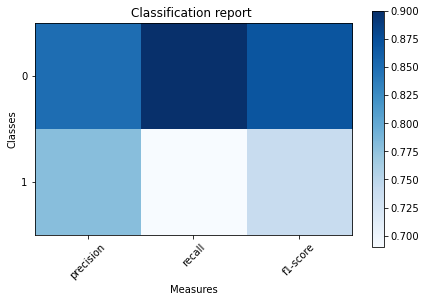

In [49]:
print(results['lr_baseline']['report'])
dsh.plot_classification_report(results['lr_baseline']['report'], n_classes=2)

There is a positive outcome in the results here in that the model far outperforms any previous simplistic model such as 'everyone dies'. An overall accuracy of 83% demonstrates significant predictive power, nevertheless, there are definitely points to consider for improvement.

The glaring point to dive into is the disparity between the metrics for each class. There is far more error occuring in the misclassifiction of passengers who survived, compared to those who died. Though there are a similar number of false positives (17) and false negatives (15), the smaller overall total of surviving passengers results in poorer results for this class.

**Ensemble method - Random forest model**

The aim is to improve on the baseline logistic regression model results using an ensemble learning method. The random forest is used to construct a multitude of decision trees that work together to provide a higher performance by selecting the modal prediciton. It is a good choice as the features do not need to be rescaled or transformed using this method. Additionally, random forests handle unbalanced data and potential outliers, such as the Fare feature in this task, very well. 

Although each individual tree has high variance and will tend to overfit to the training set, this problem is minimized by selecting the modal category prediciton from several trees. This results in moderate variance, in addition to the inherent low bias from using trees as the basis.

*Hyperparameter tuning*

An extremely important process when using the method is tuning the hyperparameters. This is achevied by utilising the sklearn grid search. Please note that the final values for the various hyperparameters are a result of starting with a broader scope of values, and then honing in on the values which overall yield the best results in each fold during cross-validation. Parts utilised for this proccess have been commented out.

In [33]:
# tuning a random forest classifier using a grid search approach, starting off broadly and then honing in on best parameters
rf = RandomForestClassifier()
rf_params = {'n_estimators':[80], 'max_depth':[50], 'max_features':[11], 'min_samples_split':[5]}
rf_tuned = GridSearchCV(estimator=rf2, param_grid=rf_params, scoring='accuracy', cv=4)
rf_tuned.fit(x_tr, y_tr)
cv_results = rf_tuned.cv_results_
#display(cv_results)
#display(rf_tuned.best_score_)
#display(rf_tuned.best_params_)

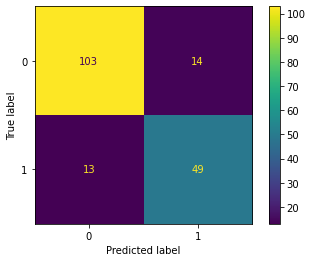

In [34]:
y_pr = rf_tuned.predict(x_te)
results['rf_tuned'] = {'matrix':confusion_matrix(y_te, y_pr), 'report':classification_report(y_te, y_pr)}

Again, the resultant confusion matrix and classification report are visualized.

In [ ]:
plot_confusion_matrix(rf_tuned, x_te, y_te)

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       117
           1       0.78      0.79      0.78        62

    accuracy                           0.85       179
   macro avg       0.83      0.84      0.83       179
weighted avg       0.85      0.85      0.85       179



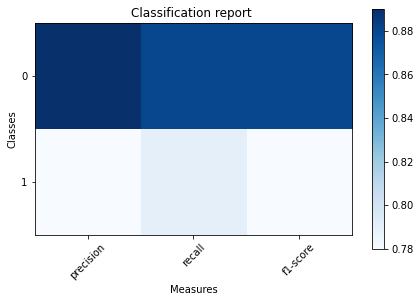

In [35]:
print(results['rf_tuned']['report'])
dsh.plot_classification_report(results['rf_tuned']['report'])

Whilst there remains a disparity between the performance for each class, there was a significant improvement from 0.69 to 0.79 for the recall metric for passengers who survived. These results show some improvement on the baseline model performance. The overall accuracy metric improved to 85%, and all the weighted averages showed similar improvements between 2% and 3%.

**Receiver operating characterictic (ROC) curve analysis**

The ROC curve is a very informative visualization of the tradeoff between sensitivity (how well a model performs on the positive class - tp/(tp+fn)) and specificity (how well a model performs on the negative class - tn/(tn+fp)) at all the different probability thresholds. The area under the curve is a therefore a very good metric for efficacy of model prediction.  

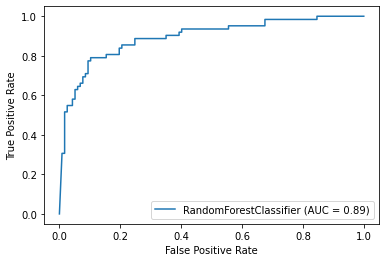

In [45]:
# plot roc curve using function imported from sklearn
plot_roc_curve(rf_tuned.best_estimator_, x_te, y_te)

The ROC curve shows a very positive performance with an area of 0.89 under the curve. This is a good strating point for this notebook. Nevertheless, this can undoubtedly be improved by re-assessing the previous steps taken in data preperation and feature engineering.

**Feature importances**

As a final point to reflect on, it is important to visualize the significance of predictive power of each feature in the decision trees. This gives a solid foundation on which to improve model performance by highlighting where the data delivers the most impact, and where reassessment in feature engineering needs to be focussed. 

In [36]:
# zip feature importances with the feature names
feature_importances = zip(df_dict['test'].columns, rf_tuned.best_estimator_.feature_importances_)
feature_importances_dict = {}
# loop through the zipped variable to extract the information into a dictionary
for feature, importance in list(feature_importances):
    feature_importances_dict[feature] = importance
# create a dataframe out of the dictionary for easy plotting using seaborn
feature_importances_df = pd.DataFrame.from_dict(feature_importances_dict, orient='index')
feature_importances_df.reset_index(inplace=True)
feature_importances_df.columns = ['Feature', 'Feature_importance']
feature_importances_df.sort_values('Feature_importance', ascending=False, inplace=True)

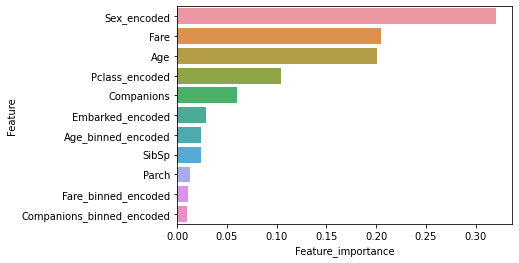

In [37]:
# plot feature importances
sns.barplot(x='Feature_importance', y='Feature', data=feature_importances_df)
plt.show()

Some of the insights here confirm the expectations from the EDA performed earlier in this notebook. Namely that the key elemenets in surviving on the Titanic were sex, fare price, age and class. It is a positive note to see that the new feature (companions) that was engineered from observations in the EDA work demonstrated good predictive power. Encoding sex and pclass with passenger survival percentage also appears to have been effective.

The key points to consider for improving this project would be to seriously reassess binning and encoding the fare and companion features as these provided very little. In general, it seems that binning and encoding the continuous features fare and age did little to help the models in comparison with the original features themselves. This is a major point to reconsider when making changes to this project in the future.

## *DEPLOY*

### **6. Submission**

This random forest model, with the optimal hyperparameters found, is finally used to make a submission to Kaggle. The following code is just simply for formatting purposes. The final predictions are made on the test set.

In [40]:
# formatting predictions for submission to kaggle competition
predictions = pd.DataFrame()
idx=[]
for i in range(418):
    idx.append(892+i)
predictions['PassengerId'] = idx
predictions['Survived'] = rf_tuned.predict(df_dict['test'])
predictions.set_index('PassengerId', inplace=True)
predictions.to_csv(r'C:\Users\steff\Documents\Python\My Projects\Titanic\sub_9.csv')

### **7. Final comments and future steps**

The results in the public leaderboard for this competition hold little meaning. Looking into the highest rated entries, it is clear they all use other data sources from the titanic passengers which is readily available online - with some recording 100% by simply finding information on who survived in the test set.

The purpose for this notebook was to limit myself to the data provided to practice my own skills and demonstrate a full data science project, from data importing and cleaning, to EDA and feature engineering, before finally producing predictive models. A good variety of techniques were demonstrated which yielded respectable scores on the final test set.

To improve this project, I will make a second attempt in which I review the lessons learnt from this notebook. Such as; filling missing age values with a more educated method utilising other features; using string manipulation method to potentially extract usfeul information from the 'Ticket' feature, re-evaluating feature engineering steps such as bin limits, reconsider other models such as gradient boosted trees. These are some of the future steps I plan to undertake in an improved attempt.

Stephane Moreau